In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from modules.helpers import feature_extraction,kmeans_preprocessing, kmeans_clustering_elbow,kmeans_clustering,plot_clusters,analyze_clusters,summarize_data
from modules.settings import POSTGRES_DB,POSTGRES_USER,POSTGRES_PASSWORD
from modules.database import create_connection,execute_read_query

NameError: name 'df_clv' is not defined

In [ ]:
# Define your database credentials and details
db_name = POSTGRES_DB
db_user = POSTGRES_USER
db_password = POSTGRES_PASSWORD
db_host = "chinook_db"  # or the IP if your database is remote
db_port = 5432

# Create a connection
connection = create_connection(db_name, db_user, db_password, db_host, db_port)

Connection to PostgreSQL DB successful


Task C: Using the data matrix that you built in the previous step, implement with a tool of your choice (Python, R, Excel, you name it) the proposed analysis. 

In [ ]:
# Query the view
query_c = '''SELECT * FROM customer_media_consumption'''

# Fetch data into DataFrame
df_c = execute_read_query(connection, query_c)
df_c[['tracks_purchased','total_spent']] = df_c[['tracks_purchased','total_spent']].astype(float)

#### Feature Extraction

In [ ]:
# Adding calculated columns: 
#   Number of transactions per customer
#   Total Number of Tracks Purchased per customer
#   Total Spent per Customer ID
#   Average spend per customer
#   Favorite Genre
#   Frequency of Purchase
#   Recency (days between 2026-01-01 and last purchase)
df_c_enhanced=feature_extraction(df_c) 

In [ ]:
# Lets change the granularity from transaction to customer
df_customers=summarize_data(df_c_enhanced)

#### K-Means Clustering

In [ ]:
# Preprocessing
df_clustering=kmeans_preprocessing(df_customers)

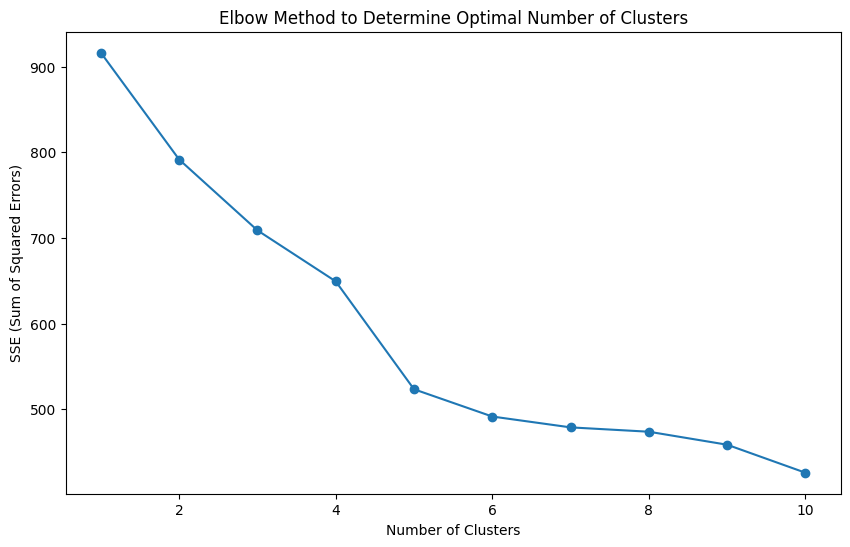

In [ ]:
# Find out optimal cluster number
kmeans_clustering_elbow(df_clustering) # Let's use 5 clusters

In [ ]:
cluster_labels=kmeans_clustering(df_clustering,clusters=5)

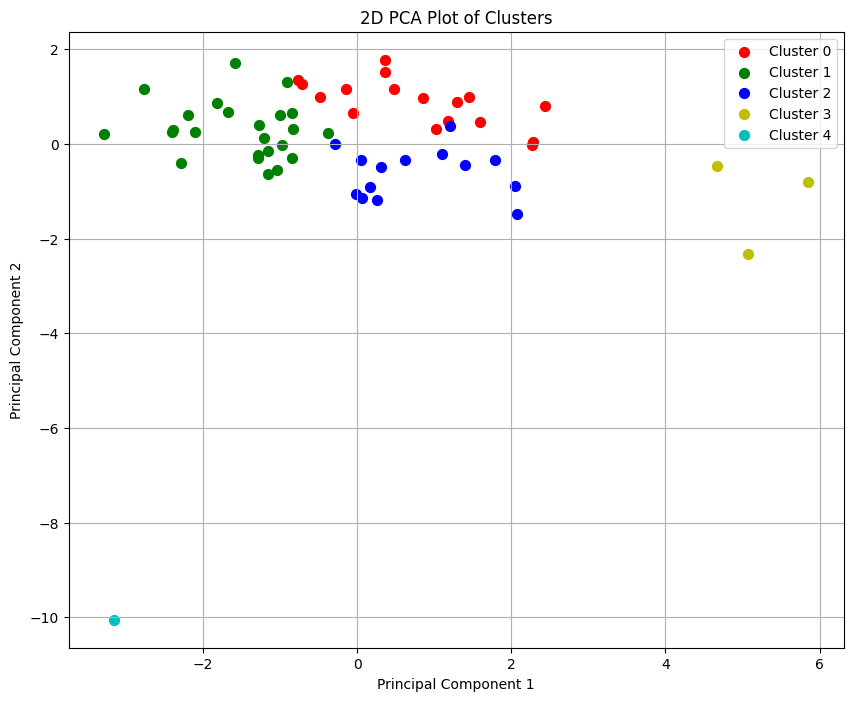

In [ ]:
# Plotting clusters using PCA
plot_clusters(df_clustering,cluster_labels)

In [ ]:
# Attach cluster labels to original df
cluster_segments=analyze_clusters(df_customers.copy(), cluster_labels)

In [ ]:
cluster_segments

,tracks_purchased,total_spent,transactions_per_customer,total_tracks_purchased,total_spent_per_customer,average_spend,days_active,purchase_frequency,recency,country,city,state,company,media_type,genre,composer,album_title,artist_name,favorite_genre
Cluster,,,,,,,,,,,,,,,,,,,
0,38.0,38.561176,27.529412,38.0,38.561176,1.412382,1644.647059,0.016754,93.058824,Canada,Amsterdam,AB,Riotur,MPEG audio file,Rock,Kurt Cobain,...And Justice For All,Iron Maiden,Rock
1,38.0,37.995000,29.916667,38.0,37.995000,1.276087,1294.000000,0.023171,271.416667,Canada,Berlin,CA,Apple Inc.,MPEG audio file,Rock,Steve Harris,Beyond Good And Evil,Iron Maiden,Rock
2,38.0,41.548571,27.071429,38.0,41.548571,1.539854,1292.071429,0.020965,273.571429,USA,Budapest,CA,Embraer - Empresa Brasileira de Aeronáutica S.A.,MPEG audio file,Rock,Adrian Smith,My Way: The Best Of Frank Sinatra [Disc 1],Led Zeppelin,Rock
3,38.0,47.620000,24.000000,38.0,47.620000,2.003442,1522.000000,0.015991,126.000000,Czech Republic,Dublin,Dublin,N/A,MPEG audio file,Rock,U2,A-Sides,Caetano Veloso,Rock
4,36.0,36.640000,25.000000,36.0,36.640000,1.465600,1151.000000,0.021701,581.000000,India,Bangalore,N/A,N/A,MPEG audio file,Rock,Miles Davis,Sex Machine,James Brown,Rock


#### Predictive Customer Lifetime Value (CLV)

In [ ]:
df_clv=df_customers.copy()
df_clv['Clusters']=cluster_labels

In [ ]:
df_clv

,country,city,state,company,media_type,genre,composer,album_title,artist_name,favorite_genre,tracks_purchased,total_spent,transactions_per_customer,total_tracks_purchased,total_spent_per_customer,average_spend,days_active,purchase_frequency,recency,Clusters
customer_id,,,,,,,,,,,,,,,,,,,,
1,Brazil,São José dos Campos,SP,Embraer - Empresa Brasileira de Aeronáutica S.A.,MPEG audio file,Rock,Herbert Vianna,Greatest Kiss,Kiss,Rock,38.0,39.62,28.0,38.0,39.62,1.415000,1245.0,0.022472,147.0,2
2,Germany,Stuttgart,None,None,MPEG audio file,Rock,Eddie Vedder,The Best Of Buddy Guy - The Millenium Collection,Eric Clapton,Rock,38.0,37.62,34.0,38.0,37.62,1.106471,1289.0,0.026357,537.0,1
3,Canada,Montréal,QC,None,MPEG audio file,Metal,Audioslave/Chris Cornell,...And Justice For All,Metallica,Metal,38.0,39.62,30.0,38.0,39.62,1.320667,1289.0,0.023256,103.0,1
4,Norway,Oslo,None,None,MPEG audio file,Rock,"Angus Young, Malcolm Young, Brian Johnson",Judas 0: B-Sides and Rarities,Led Zeppelin,Rock,38.0,39.62,28.0,38.0,39.62,1.415000,1735.0,0.016129,90.0,0
5,Czech Republic,Prague,None,JetBrains s.r.o.,MPEG audio file,Rock,Steve Harris,Ao Vivo [IMPORT],Iron Maiden,Rock,38.0,40.62,27.0,38.0,40.62,1.504444,1245.0,0.021669,240.0,2
6,Czech Republic,Prague,None,None,MPEG audio file,Rock,U2,Prenda Minha,Caetano Veloso,Rock,38.0,49.62,28.0,38.0,49.62,1.772143,1586.0,0.017643,49.0,3
7,Austria,Vienne,None,None,MPEG audio file,Rock,"Adam Clayton, Bono, Larry Mullen & The Edge",A Real Dead One,U2,Rock,38.0,42.62,29.0,38.0,42.62,1.469655,1289.0,0.022481,196.0,2
8,Belgium,Brussels,None,None,MPEG audio file,Rock,Jagger/Richards,Big Ones,Faith No More,Rock,38.0,37.62,27.0,38.0,37.62,1.393333,1735.0,0.015553,89.0,0
9,Denmark,Copenhagen,None,None,MPEG audio file,Rock,Anthony Kiedis/Chad Smith/Flea/John Frusciante,Acústico MTV,Red Hot Chili Peppers,Rock,38.0,37.62,24.0,38.0,37.62,1.567500,1245.0,0.019262,333.0,2
